In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


### Image Compression: The encoder downsamples the input image using convolutional layers, producing a low-resolution latent feature map z_e.

### Codebook Quantization: Each latent vector is matched to the nearest entry in a learned codebook, converting continuous features into discrete indices (tokens).

### Discrete Representation: These discrete indices represent compressed versions of the original image, making them ideal for use in transformer-based models.

### Straight-Through Estimator: Gradients are passed through the encoder as if quantization didn’t happen, enabling end-to-end training despite the discrete bottleneck.

### Reconstruction: The decoder upsamples the quantized latent features back into full-resolution images using transposed convolutions.

### End Goal: This discrete bottleneck allows the model to tokenize images, making them compatible with language-modeling techniques like GPT.

In [2]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, embedding_dim, 1)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 1), nn.Tanh()
        )

    def forward(self, x):
        z_e = self.encoder(x)  # [B, D, H, W]
        flat_z = z_e.permute(0, 2, 3, 1).contiguous().view(-1, z_e.size(1))

        # Quantization
        dists = (flat_z.unsqueeze(1) - self.codebook.weight).pow(2).sum(-1)
        indices = dists.argmin(1)
        z_q = self.codebook(indices).view(z_e.shape).permute(0, 2, 3, 1).contiguous()
        z_q = z_q.permute(0, 3, 1, 2)

        # Straight-through estimator
        z_q_st = z_e + (z_q - z_e).detach()

        x_recon = self.decoder(z_q_st)
        return x_recon, z_e, z_q


### This loss function balances three objectives: image reconstruction accuracy, codebook embedding quality, and commitment of the encoder to discrete codes.
### It ensures that encoded features stay close to codebook vectors while still allowing gradients to flow during training.

In [3]:
def vqvae_loss(x, x_recon, z_e, z_q, beta=0.25):
    recon_loss = F.mse_loss(x_recon, x)
    commit_loss = F.mse_loss(z_e.detach(), z_q)
    codebook_loss = F.mse_loss(z_e, z_q.detach())
    return recon_loss + codebook_loss + beta * commit_loss


### Downloading the CIFAR10 dataset. We will attempt to reconstruct CIFAR10 images using the VQ-VAE

In [4]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize, Resize

transform = Compose([Resize(32), ToTensor(), Normalize([0.5]*3, [0.5]*3)])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


100%|██████████| 170M/170M [00:11<00:00, 15.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
device = "cuda"
num_epochs = 50

### Training the model with Adam for 50 epochs

In [6]:
from tqdm import tqdm

model = VQVAE().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    epoch_loss = 0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}", leave=False)

    for x, _ in pbar:
        x = x.to(device)
        x_recon, z_e, z_q = model(x)
        loss = vqvae_loss(x, x_recon, z_e, z_q)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}: avg_loss = {epoch_loss / len(trainloader):.4f}")


Epoch 1: avg_loss = 0.8199


Epoch 2: avg_loss = 0.6935


Epoch 3: avg_loss = 0.5777


Epoch 4: avg_loss = 0.5711


Epoch 5: avg_loss = 0.5361


Epoch 6: avg_loss = 0.5007


Epoch 7: avg_loss = 0.4746


Epoch 8: avg_loss = 0.4794


Epoch 9: avg_loss = 0.4727


Epoch 10: avg_loss = 0.4512


Epoch 11: avg_loss = 0.4578


Epoch 12: avg_loss = 0.4550


Epoch 13: avg_loss = 0.4665


Epoch 14: avg_loss = 0.4493


Epoch 15: avg_loss = 0.4721


Epoch 16: avg_loss = 0.4731


Epoch 17: avg_loss = 0.4637


Epoch 18: avg_loss = 0.4780


Epoch 19: avg_loss = 0.4877


Epoch 20: avg_loss = 0.4826


Epoch 21: avg_loss = 0.4802


Epoch 22: avg_loss = 0.4988


Epoch 23: avg_loss = 0.4943


Epoch 24: avg_loss = 0.5060


Epoch 25: avg_loss = 0.4996


Epoch 26: avg_loss = 0.5231


Epoch 27: avg_loss = 0.5369


Epoch 28: avg_loss = 0.5264


Epoch 29: avg_loss = 0.5411


Epoch 30: avg_loss = 0.5461


Epoch 31: avg_loss = 0.5230


Epoch 32: avg_loss = 0.5355


Epoch 33: avg_loss = 0.5462


Epoch 34: avg_loss = 0.5485


Epoch 35: avg_loss = 0.5658


Epoch 36: avg_loss = 0.5552


Epoch 37: avg_loss = 0.5644


Epoch 38: avg_loss = 0.5642


Epoch 39: avg_loss = 0.5804


Epoch 40: avg_loss = 0.5823


Epoch 41: avg_loss = 0.5737


Epoch 42: avg_loss = 0.5881


Epoch 43: avg_loss = 0.6001


Epoch 44: avg_loss = 0.5876


Epoch 45: avg_loss = 0.5956


Epoch 46: avg_loss = 0.5996


Epoch 47: avg_loss = 0.6094


Epoch 48: avg_loss = 0.6019


Epoch 49: avg_loss = 0.6021


Epoch 50: avg_loss = 0.6341


### Visualizing the images and their reconstructions

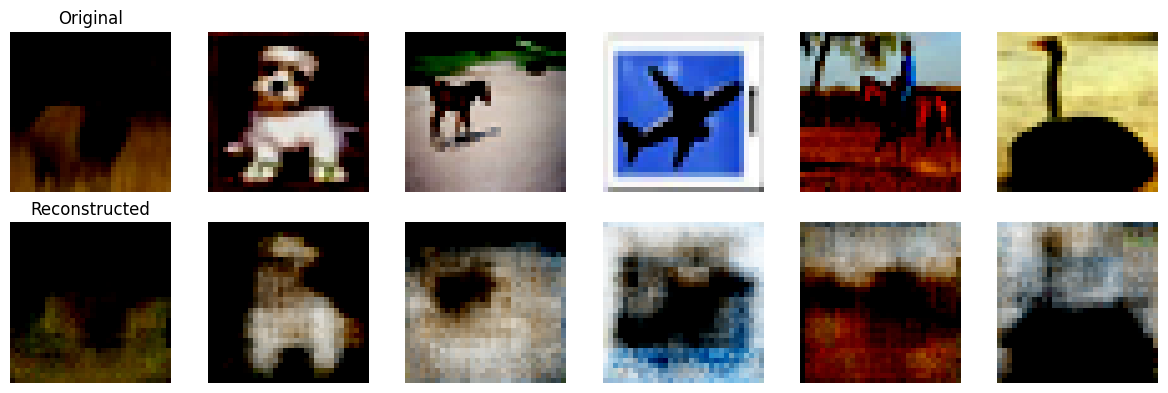

In [7]:
import matplotlib.pyplot as plt

x, _ = next(iter(trainloader))
x = x.to(device)

with torch.no_grad():
    x_recon, _, _ = model(x)

def show_images(orig, recon, num=6):
    orig = orig[:num].cpu()
    recon = recon[:num].cpu()

    plt.figure(figsize=(num * 2, 4))
    for i in range(num):
        # Original
        plt.subplot(2, num, i + 1)
        plt.imshow(orig[i].permute(1, 2, 0).clamp(0, 1))
        plt.axis('off')
        if i == 0: plt.title("Original")

        # Reconstructed
        plt.subplot(2, num, num + i + 1)
        plt.imshow(recon[i].permute(1, 2, 0).clamp(0, 1))
        plt.axis('off')
        if i == 0: plt.title("Reconstructed")

    plt.tight_layout()
    plt.show()

show_images(x, x_recon)


In [8]:
with torch.no_grad():
    z_e = model.encoder(x)  # shape [B, D, H, W]
    z_flat = z_e.permute(0, 2, 3, 1).reshape(-1, model.codebook.embedding_dim)
    dists = torch.cdist(z_flat, model.codebook.weight)
    tokens = dists.argmin(dim=1).reshape(x.size(0), z_e.size(2), z_e.size(3))  # [B, H, W]
    token_seqs = tokens.view(x.size(0), -1)  # Flatten for transformer


### Visualizing the learned tokens

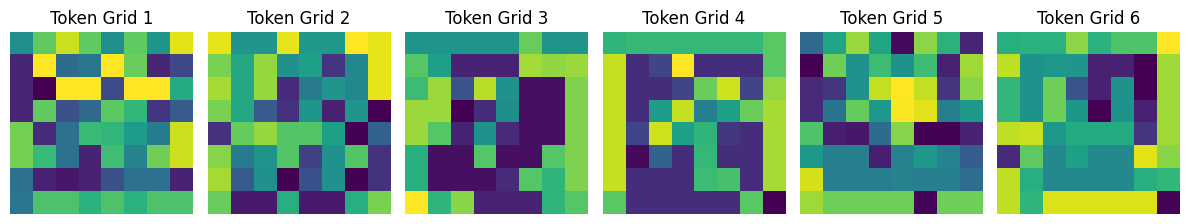

In [9]:
def visualize_token_grid(tokens, num_images=6):
    plt.figure(figsize=(num_images * 2, 2.5))
    for i in range(num_images):
        grid = tokens[i].cpu().numpy()  # shape [H, W]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(grid, cmap='viridis')  # or 'plasma', 'gray'
        plt.title(f"Token Grid {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_token_grid(tokens, num_images=6)


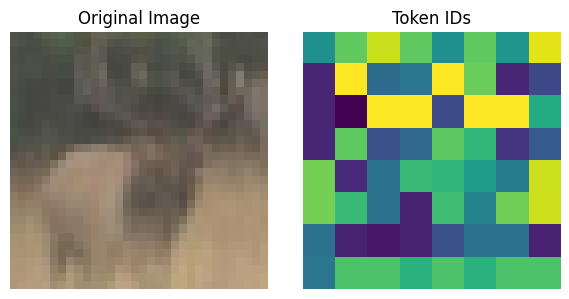

In [10]:
def show_image_and_tokens(imgs, tokens, index=0):
    img = imgs[index].cpu().permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
    img = (img * 0.5 + 0.5).clamp(0, 1)        # unnormalize

    token_grid = tokens[index].cpu().numpy()

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(token_grid, cmap='viridis')
    plt.title("Token IDs")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show_image_and_tokens(x, tokens, index=0)
